CNN 

Successfully loaded 5000 samples
Number of classes: 50
Epoch 1/100


2025-06-06 01:09:59.590352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-06-06 01:09:59.775330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


110/110 [==============================] - ETA: 0s - loss: 4.5419 - accuracy: 0.0306 - auc: 0.5718

2025-06-06 01:10:25.340583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 30s 199ms/step - loss: 4.5419 - accuracy: 0.0306 - auc: 0.5718 - val_loss: 4.0234 - val_accuracy: 0.0200 - val_auc: 0.5048 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - 14s 128ms/step - loss: 4.1084 - accuracy: 0.0603 - auc: 0.6432 - val_loss: 4.4276 - val_accuracy: 0.0253 - val_auc: 0.5057 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - 14s 129ms/step - loss: 3.9364 - accuracy: 0.0760 - auc: 0.6727 - val_loss: 5.0786 - val_accuracy: 0.0200 - val_auc: 0.5011 - lr: 1.0000e-04
Epoch 4/100
110/110 [==============================] - 14s 127ms/step - loss: 3.8021 - accuracy: 0.0906 - auc: 0.7029 - val_loss: 5.8689 - val_accuracy: 0.0200 - val_auc: 0.4930 - lr: 1.0000e-04
Epoch 5/100
110/110 [==============================] - 14s 131ms/step - loss: 3.6933 - accuracy: 0.0977 - auc: 0.7267 - val_loss: 5.0917 - val_accuracy: 0.0200 - val_auc: 0.5539 - lr: 1.0000e-04
Epoch 6/100
110/110 [================

2025-06-06 01:31:49.787792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 1s 22ms/step

Classification Report:
                            precision    recall  f1-score   support

               Andean Guan       0.80      0.53      0.64        30
          Band-tailed Guan       1.00      0.30      0.46        30
            Barred Tinamou       1.00      0.70      0.82        30
        Bartlett's Tinamou       0.79      0.37      0.50        30
                Baudo Guan       0.80      0.67      0.73        30
              Bearded Guan       0.87      0.90      0.89        30
       Berlepsch's Tinamou       0.71      0.17      0.27        30
            Biak Scrubfowl       0.40      0.60      0.48        30
      Black-capped Tinamou       1.00      0.57      0.72        30
 Black-fronted Piping Guan       0.47      0.77      0.58        30
             Brown Tinamou       1.00      0.20      0.33        30
                Cauca Guan       0.78      0.47      0.58        30
          Chaco Chachalaca       0.86

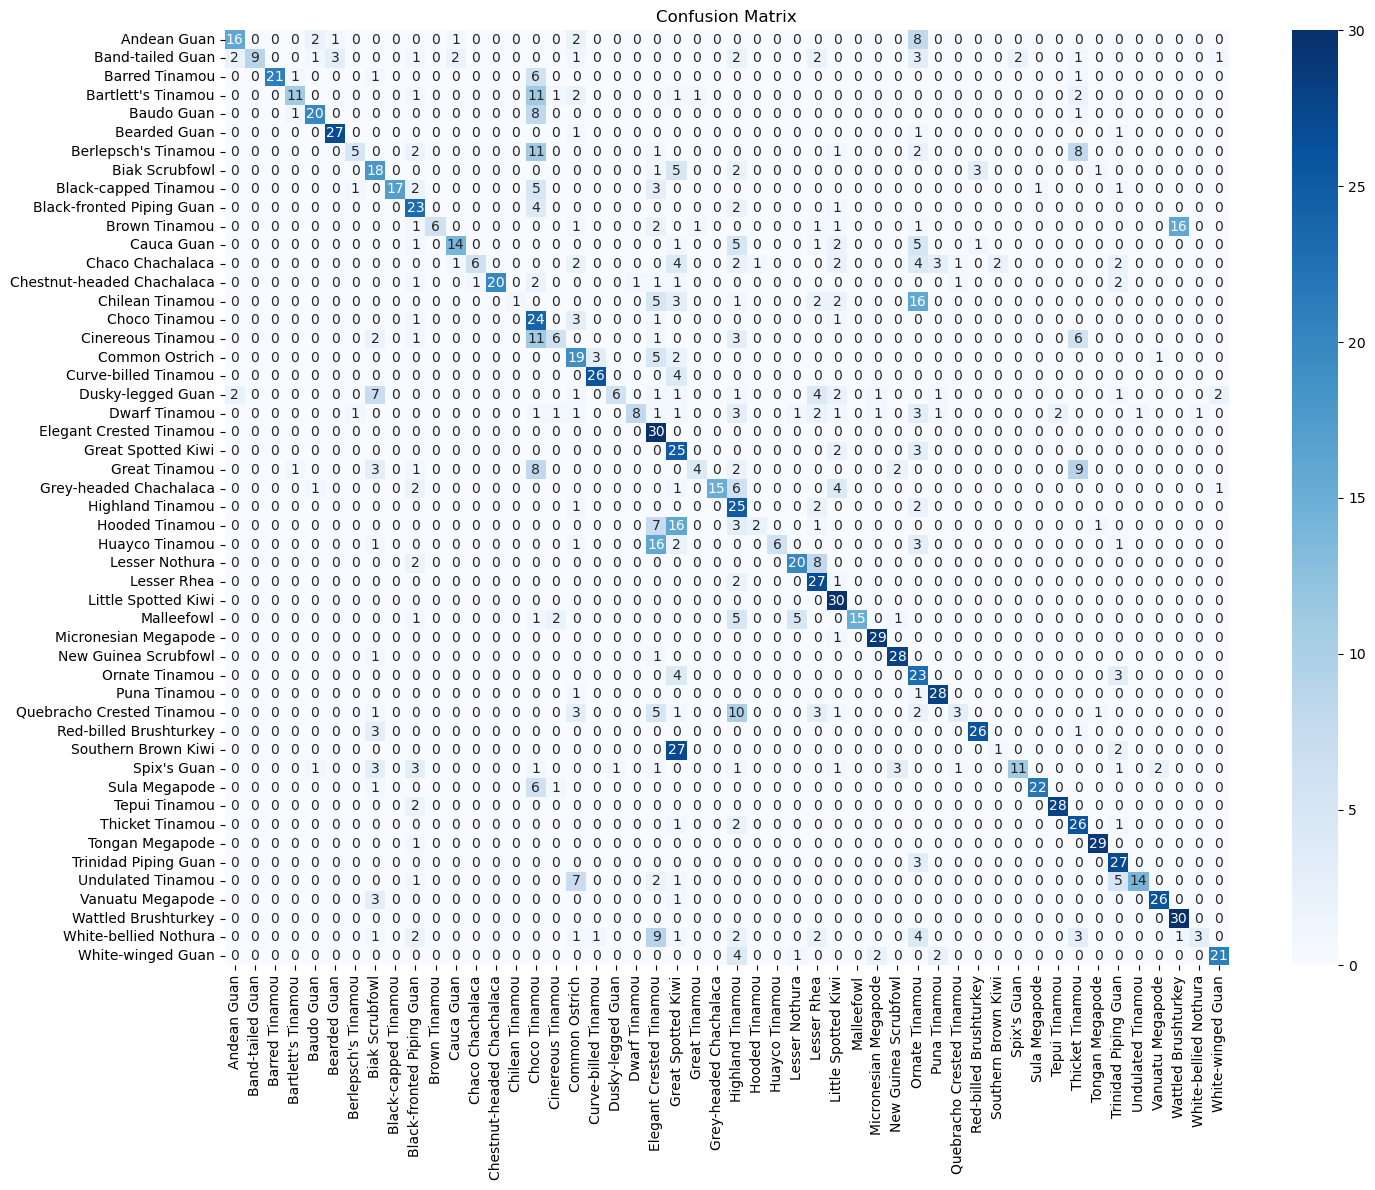

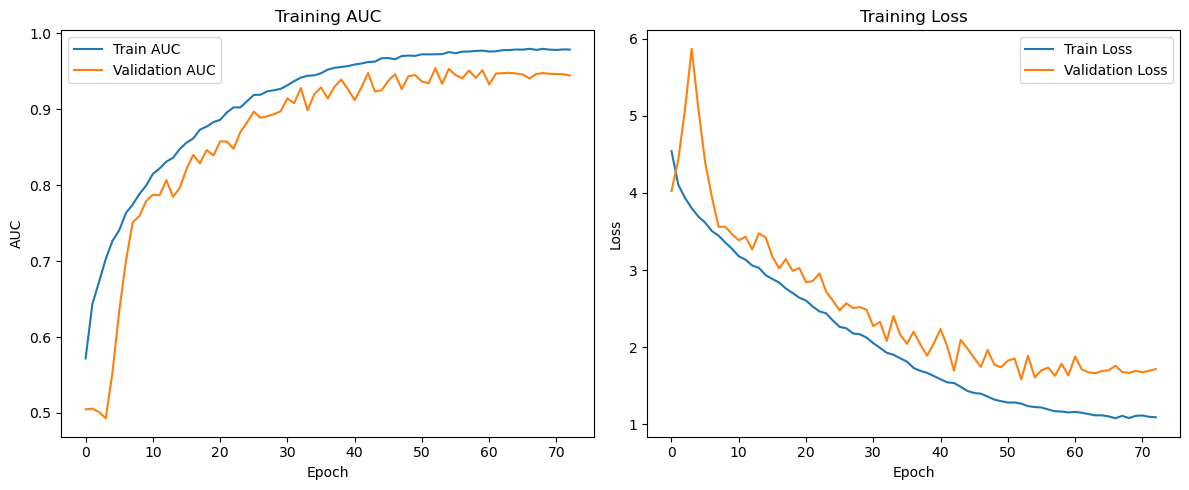

In [8]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            precision_recall_fscore_support, accuracy_score,
                            balanced_accuracy_score, matthews_corrcoef,
                            cohen_kappa_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
AUDIO_DIR = DATA_DIR / 'processed' / 'birdcall_segments_5s_TOP50'
METADATA_PATH = DATA_DIR / 'processed' / 'birdcall_metadata_TOP50.csv' 
MODEL_DIR = BASE_DIR / 'models'
METRICS_DIR = BASE_DIR / 'metrics'

# Audio parameters
SAMPLE_RATE = 22050
DURATION = 5
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
MAX_PAD_LEN = int(np.ceil((SAMPLE_RATE * DURATION) / HOP_LENGTH))

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100
INIT_LR = 1e-4

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

def load_and_preprocess_audio(file_path):
    """Audio preprocessing without augmentation"""
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS,
                                         n_fft=N_FFT, hop_length=HOP_LENGTH)
        S_dB = librosa.power_to_db(S, ref=np.max)
        
        # Normalize
        S_dB = (S_dB - np.min(S_dB)) / (np.max(S_dB) - np.min(S_dB) + 1e-8)
        
        # Padding
        if S_dB.shape[1] < MAX_PAD_LEN:
            pad_width = MAX_PAD_LEN - S_dB.shape[1]
            S_dB = np.pad(S_dB, ((0,0), (0,pad_width)), mode='constant')
        else:
            S_dB = S_dB[:, :MAX_PAD_LEN]
            
        return S_dB[..., np.newaxis]
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_data_with_metadata():
    """Load audio data with labels from metadata CSV"""
    # Read metadata
    metadata = pd.read_csv(METADATA_PATH)
    
    X_audio = []
    y_species = []
    valid_files = []
    
    label_encoder = LabelEncoder()
    
    # First pass to collect all species for label encoding
    all_species = metadata['species'].unique()
    label_encoder.fit(all_species)
    
    for _, row in metadata.iterrows():
        audio_path = os.path.join(AUDIO_DIR, row['filename'])
        if not os.path.exists(audio_path):
            print(f"File not found: {audio_path}")
            continue
            
        spec = load_and_preprocess_audio(audio_path)
        if spec is None:
            continue
            
        X_audio.append(spec)
        y_species.append(row['species'])
        valid_files.append(row['filename'])
    
    # Convert labels to categorical
    y_encoded = label_encoder.transform(y_species)
    y_categorical = to_categorical(y_encoded)
    
    print(f"Successfully loaded {len(X_audio)} samples")
    print(f"Number of classes: {len(label_encoder.classes_)}")
    return np.array(X_audio), np.array(y_categorical), label_encoder

def build_pure_cnn_model(input_shape, num_classes):
    """Pure CNN model for spectrogram processing"""
    inputs = Input(shape=input_shape, name='audio_input')
    
    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Conv Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Classifier
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluation function"""
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    y_pred_proba = model.predict(X_test)
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_true, y_pred),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
        'auc_ovr': roc_auc_score(y_test, y_pred_proba, multi_class='ovr'),
        'auc_ovo': roc_auc_score(y_test, y_pred_proba, multi_class='ovo'),
    }
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    metrics['per_class'] = {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    
    # Save metrics
    metrics_file = METRICS_DIR / 'evaluation_metrics_CNN.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Print results
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(confusion_matrix(y_true, y_pred), 
                annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'confusion_matrix_CNN.png', dpi=300)
    plt.show()
    
    return metrics

if __name__ == "__main__":
    # Load data
    X_audio, y_categorical, label_encoder = load_data_with_metadata()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_audio, y_categorical,
        test_size=0.3,
        stratify=np.argmax(y_categorical, axis=1),
        random_state=42
    )
    
    # Class weights
    class_indices = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced',
                                       classes=np.unique(class_indices),
                                       y=class_indices)
    class_weights = dict(enumerate(class_weights))
    
    # Build model
    model = build_pure_cnn_model(
        input_shape=X_audio.shape[1:],
        num_classes=len(label_encoder.classes_)
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True),
        ModelCheckpoint(MODEL_DIR / 'best_CNN.h5', monitor='val_auc', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max')
    ]
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save model
    model.save(MODEL_DIR / 'final_CNN.h5')
    
    # Save training history
    history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
    with open(METRICS_DIR / 'training_history_CNN.json', 'w') as f:
        json.dump(history_dict, f, indent=4)
    
    # Evaluate
    evaluate_model(model, X_test, y_test, label_encoder)
    
    # Plot training
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'training_history_CNN.png', dpi=300)
    plt.show()